Directional statistics to examine camera rotation angle uniformity
===============

This notebook demonstrates a new metric for evaluating the uniformity of periodic variables (that is, periodic parameters, not variable stars!), such as camera rotation angles.  Naive mean or RMS metrics are not quite sufficient for this task, as they won't identify 0 degrees and 360 degrees as the same angle.  For instance, the naive mean of 1 degree and 359 degrees is (360 degrees)/2 = 180 degrees; which is the maximally wrong answer.

MAF already includes the metrics _MeanAngleMetric_ and _RmsAngleMetric_, which are designed to handle the $2\pi$ periodicity of angular variables.

_MeanAngleMetric_ implements the directional statistic recommended [here](https://en.wikipedia.org/wiki/Mean_of_circular_quantities#Mean_of_angles), which defines an angular mean by averaging the sine and cosine of the set of angles $\{\alpha_i\}$ and converting these back into an angle by taking the (quadrant aware) arctangent:
$$\bar{\alpha} = \mathrm{atan2}\left(\frac{\sum \sin \alpha_i}{n}, \frac{\sum \cos \alpha_i}{n}\right).$$
Intuitively, we are mapping the angles into 2D unit vectors on a unit circle, and averaging in this 2D space.  The arctangent then converts this average back into an angle.

The _RmsAngleMetric_ works by first adjusting the phase of the angles $\{\alpha_i\}$ such that the largest gap between phase-adjusted angles is aligned to the end of the interval $[0, 2 \pi)$.  The RMS of the phase-adjusted angles is then returned.  While this phase adjustment does make _RmsAngleMetric_ independent of the original phases of the input angles, it is potentially non-robust since the insertion or deletion of a single angle may significantly change the zero-point of the phase-adjustment by, for example, splitting the previous largest gap in angles upon insertion or creating a new largest gap upon deletion.

We suggest an alternate metric based on the [directional spread](https://en.wikipedia.org/wiki/Directional_statistics#Measures_of_location_and_spread).
The angular spread metric is defined 
$$ \mathrm{Spread}(\alpha) = 1 - \sqrt{\left(\frac{\sum \sin \alpha_i}{n}\right)^2 + \left(\frac{\sum \cos \alpha_i}{n}\right)^2}. $$
Intuitively, this measures the radial offset from 0 of the mean position of angles mapped into unit vectors.  In one limit, the unit vectors corresponding to a uniform distribution of angles average to 0 in two dimensions, which makes the angular spread approach 1.  In the opposite limit, a delta function distribution of angles (i.e., a maximally non-uniform distribution of angles), maps to a 2D distribution clustered at the edge of the unit circle, which then leads to a spread metric of 0.  This metric is robust to both the phases of input angles and small perturbations in individual angles or insertion/deletion of individual angles.  We call this metric the _AngularSpreadMetric_.

---------

We mimic the steps in the ipython notebook GalaxyCounts.ipynb to demonstrate AngularSpreadMetric to investigate the distribution of camera rotation angles with respect to the sky for each field.

import the python and MAF items we need.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# Import the contributed metrics, to get AngularSpreadMetric
from mafContrib import AngularSpreadMetric

/Users/lynnej/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Connect to OpSim output

In [2]:
runName = 'enigma_1189'
dbfile = '../../tutorials/enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(dbfile)

Look at r-band wide-fast-deep observations.

In [3]:
propIds, propTags = opsdb.fetchPropInfo()
wfdWhere = mafUtils.createSQLWhere('WFD', propTags)
sqlconstraint  = wfdWhere + ' and filter="r"'
print sqlconstraint

propID = 364 and filter="r"


The distribution of rotation angles at any one point on the sky can be influenced by the x-y dither pattern of observations, as the rotation angles for a particular field become intermixed with the rotation angles for neighboring fields.  Hence, we will investigate different dither patterns.

In [4]:
# Set up a dictionary to hold the metric bundles, for each different dithering pattern.
myBundles = {}

In [5]:
# Set up the undithered version.
nside = 64
raCol = 'fieldRA'
decCol = 'fieldDec'
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
metric = AngularSpreadMetric('rotSkyPos')
myBundles['undithered'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    runName=runName, metadata='No dithering')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
# Set up a spiral dithered version. 
raCol = 'spiralDitherFieldNightRa'
decCol = 'spiralDitherFieldNightDec'
spiralstacker = stackers.SpiralDitherFieldNightStacker()
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['spiral'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    stackerList=[spiralstacker], runName=runName, metadata='Spiral dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
# Set up a random dither, with a specific random seed.
raCol = 'randomDitherFieldNightRa'
decCol = 'randomDitherFieldNightDec'
randomstacker = stackers.RandomDitherFieldNightStacker(randomSeed=43)
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['random'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    stackerList=[randomstacker], runName=runName, metadata='Random dither')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Shear systematics are invariant under rotations by $\pi$ radians.  We can account for this by specifying that the RotSkyPos variable should be interpretted as having period $\pi$ instead of the default $2 \pi$ when creating the _AngularSpreadMetric_.

In [13]:
# Undithered, pi periodicity
nside = 64
raCol = 'fieldRA'
decCol = 'fieldDec'
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
metric = AngularSpreadMetric('rotSkyPos', period=np.pi)
myBundles['unditheredPi'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    runName=runName, metadata='No dithering. Pi period.')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [14]:
# Set up a spiral dithered version. 
raCol = 'spiralDitherFieldNightRa'
decCol = 'spiralDitherFieldNightDec'
spiralstacker = stackers.SpiralDitherFieldNightStacker()
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['spiralPi'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    stackerList=[spiralstacker], runName=runName, metadata='Spiral dither. Pi period.')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [15]:
# Set up a random dither, with a specific random seed.
raCol = 'randomDitherFieldNightRa'
decCol = 'randomDitherFieldNightDec'
randomstacker = stackers.RandomDitherFieldNightStacker(randomSeed=43)
slicer = slicers.HealpixSlicer(nside=nside, lonCol=raCol, latCol=decCol)
myBundles['randomPi'] = metricBundles.MetricBundle(
    metric=metric, slicer=slicer, sqlconstraint=sqlconstraint,
    stackerList=[randomstacker], runName=runName, metadata='Random dither. Pi period.')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Setup output directory and keep track of metrics that have been run.

In [16]:
outDir = 'angularSpread'
resultsDb = db.ResultsDb(outDir=outDir)
mb = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)

Run the metrics.

In [17]:
mb.runAll()

Querying database with constraint propID = 364 and filter="r"
Found 463866 visits
Running:  ['undithered', 'unditheredPi']
Completed metric generation.
Running:  ['randomPi', 'random']
Completed metric generation.
Running:  ['spiral', 'spiralPi']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Make plots!

Plotting figures with propID = 364 and filter="r" sqlconstraint now.
monopole: 0.338178  dipole: lon: 132.655, lat: -65.4057, amp: 0.391763
monopole: 0.751066  dipole: lon: 141.292, lat: 47.4737, amp: 0.160937
monopole: 0.338665  dipole: lon: 131.736, lat: -64.8122, amp: 0.370218
monopole: 0.338045  dipole: lon: 131.456, lat: -64.6802, amp: 0.368847
monopole: 0.771808  dipole: lon: 142.48, lat: 53.4603, amp: 0.185464
monopole: 0.752692  dipole: lon: 141.14, lat: 48.3858, amp: 0.164449
Plotting complete.


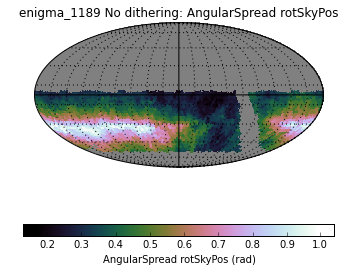

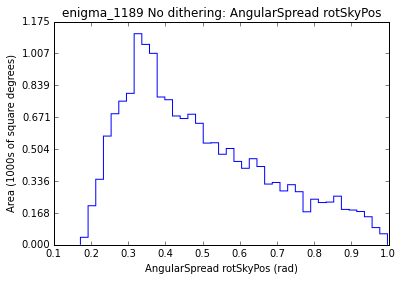

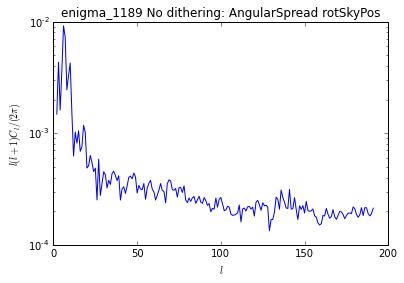

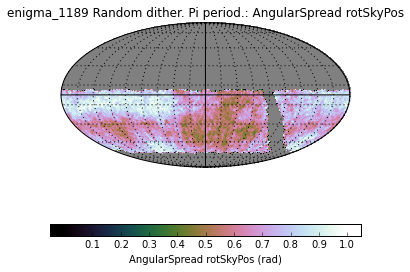

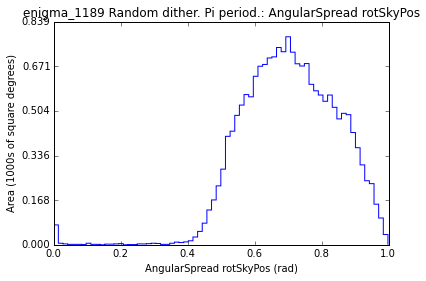

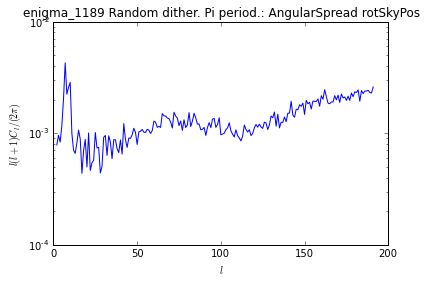

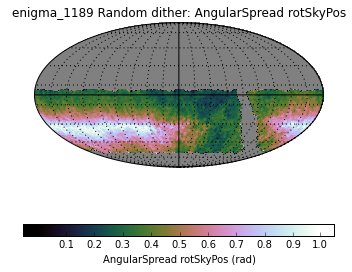

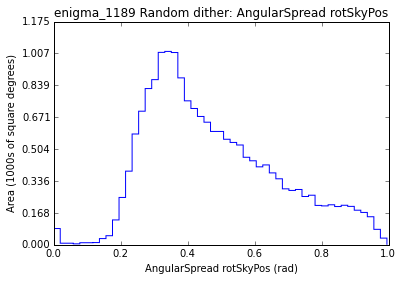

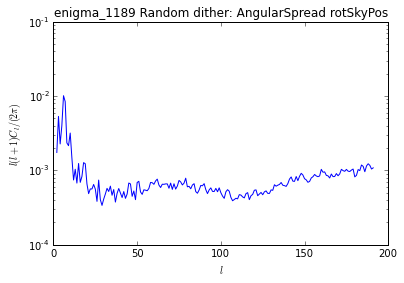

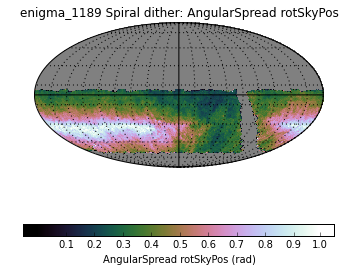

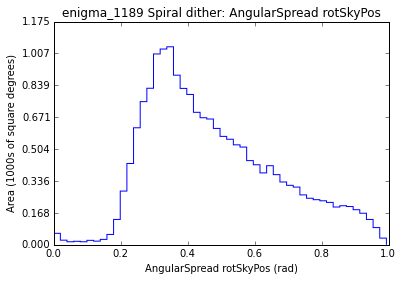

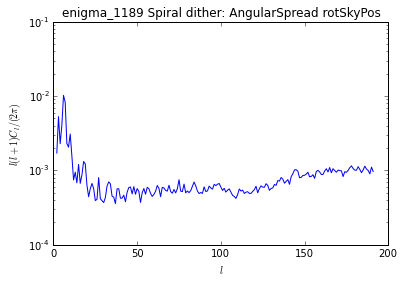

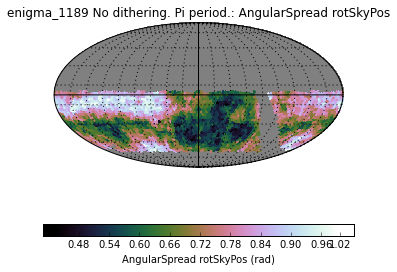

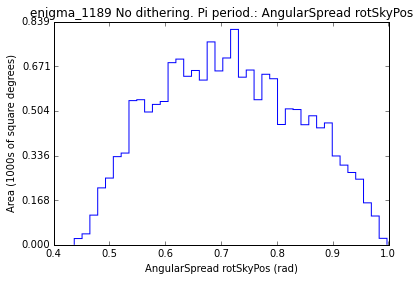

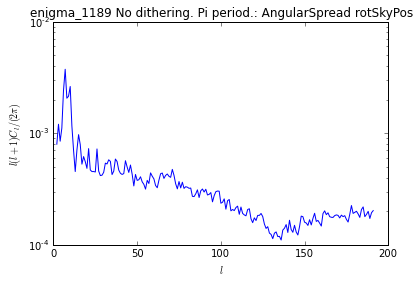

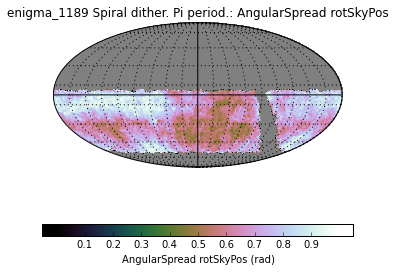

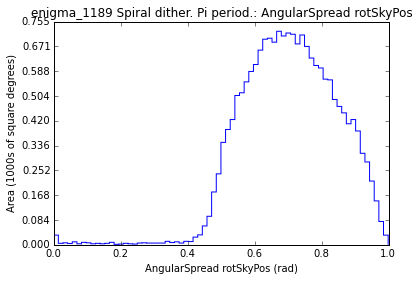

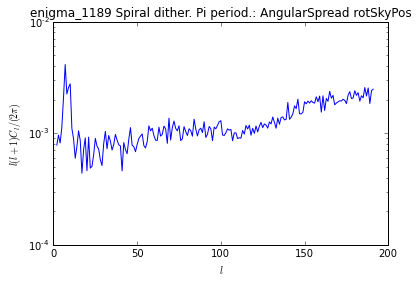

In [18]:
mb.plotAll(closefigs=False)